In [51]:
# Load the HDF5 file

file_path = 'C:\\Users\\liors.WISMAIN\\Weizmann Institute Dropbox\\Lior Segev\\Clients\\Ofer_Izhar\\Lital\\Data\\Mobile.2025.09.30.5025.04.001.sensor.h5'
file_path_meta = 'C:\\Users\\liors.WISMAIN\\Weizmann Institute Dropbox\\Lior Segev\\Clients\\Ofer_Izhar\\Lital\\Data\\Mobile.2025.09.30.5025.04.001.h5'

# resample to 50ms define a variable for the resampling rate
resample_rate = 0.01

# statistics for the data every 30 seconds
stats_every = '1s'

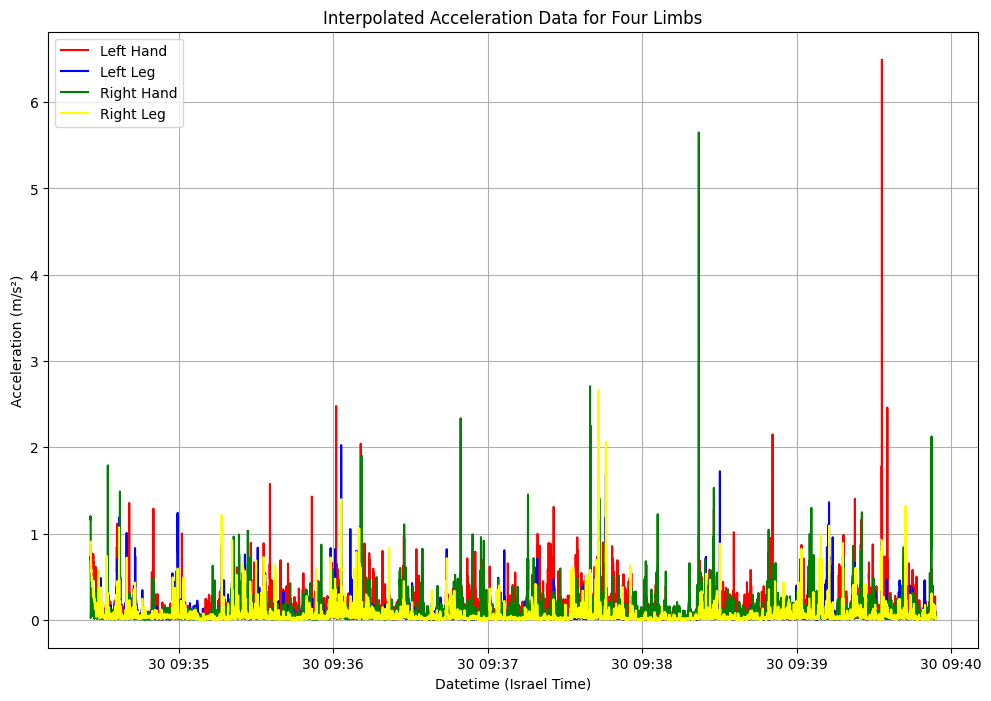

In [52]:
import h5py
import numpy as np
from datetime import datetime, timedelta
import pytz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd



# Define the colors for each limb
colors = {
    'Left Hand': 'red',
    'Right Hand': 'green',
    'Left Leg': 'blue',
    'Right Leg': 'yellow',
}

# Step 1: Load and extract data for all four limbs
limb_data = {}
with h5py.File(file_path, 'r') as h5_file:
    limb_data['Left Hand'] = h5_file['measurement/MetaWear Sensors Control/left_hand_data'][:]
    limb_data['Left Leg'] = h5_file['measurement/MetaWear Sensors Control/left_leg_data'][:]
    limb_data['Right Hand'] = h5_file['measurement/MetaWear Sensors Control/right_hand_data'][:]
    limb_data['Right Leg'] = h5_file['measurement/MetaWear Sensors Control/right_leg_data'][:]

# Step 2: Convert timestamps to actual date and time
epoch_start = datetime(1970, 1, 1)  # Unix epoch
formatted_data = {}
for limb, time_accel in limb_data.items():
    times = [epoch_start + timedelta(seconds=t) for t in time_accel[:, 0]]
    formatted_data[limb] = {
        "datetime": np.array(times),
        "acc_x": time_accel[:, 1],
        "acc_y": time_accel[:, 2],
        "acc_z": time_accel[:, 3]
    }

# Step 3: Adjust timestamps to Israel timezone
israel_tz = pytz.timezone("Asia/Jerusalem")
formatted_data_israel = {}
for limb, data in formatted_data.items():
    times_israel = [t.replace(tzinfo=pytz.utc).astimezone(israel_tz) for t in data["datetime"]]
    formatted_data_israel[limb] = {
        "datetime": np.array(times_israel),
        "acceleration": np.sqrt(data["acc_x"]**2 + data["acc_y"]**2 + data["acc_z"]**2)
    }

# Step 4: Create a unified timeline with 50 ms (0.05 seconds) period
start_time = max(data["datetime"][0] for data in formatted_data_israel.values())
end_time = min(data["datetime"][-1] for data in formatted_data_israel.values())
unified_timeline = np.arange(start_time.timestamp(), end_time.timestamp(), resample_rate)

# Step 5: Interpolate the data for all limbs onto the unified timeline
interpolated_data = {}
for limb, data in formatted_data_israel.items():
    # Convert datetime to timestamps for interpolation
    timestamps = np.array([dt.timestamp() for dt in data["datetime"]])
    acceleration = data["acceleration"]
    
    # Create interpolation function
    interp_func = interp1d(timestamps, acceleration, kind='linear', fill_value="extrapolate")
    
    # Apply interpolation on the unified timeline
    interpolated_acceleration = interp_func(unified_timeline)
    interpolated_data[limb] = interpolated_acceleration

# Step 6: Plot the interpolated data
plt.figure(figsize=(12, 8))
unified_datetime = [datetime.fromtimestamp(ts, tz=israel_tz) for ts in unified_timeline]
for limb, interpolated_accel in interpolated_data.items():
    plt.plot(unified_datetime, interpolated_accel, label=limb, color=colors[limb])

plt.title("Interpolated Acceleration Data for Four Limbs")
plt.xlabel("Datetime (Israel Time)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid()
plt.show()


In [53]:
# create a new dataframe from interpolated_data and unified_datetime
interpolated_df = pd.DataFrame(interpolated_data, index=unified_datetime)
interpolated_df.index.name = 'datetime'
interpolated_df

,Left Hand,Left Leg,Right Hand,Right Leg
datetime,,,,
2025-09-30 09:34:25.683231+03:00,0.714913,0.720953,1.163777,0.885163
2025-09-30 09:34:25.693231+03:00,0.720131,0.710551,1.188600,0.886539
2025-09-30 09:34:25.703231+03:00,0.717210,0.708174,1.196983,0.883708
2025-09-30 09:34:25.713231+03:00,0.703006,0.708547,1.202262,0.885580
2025-09-30 09:34:25.723231+03:00,0.699499,0.712037,1.193520,0.893409
...,...,...,...,...
2025-09-30 09:39:54.032918+03:00,0.089900,0.010881,0.048863,0.007227
2025-09-30 09:39:54.042918+03:00,0.056308,0.020957,0.045012,0.012403
2025-09-30 09:39:54.052918+03:00,0.046410,0.030148,0.053819,0.020067


In [54]:
import h5py
import pandas as pd
from datetime import datetime
import pytz

# Load the HDF5 file

# Step 1: Extract the events table from the HDF5 file
events_data = None
with h5py.File(file_path_meta, 'r') as h5_file:
    events_data = h5_file['measurement/Task Management/events'][:]

# Step 2: Convert to a pandas DataFrame for better readability
events_table = pd.DataFrame(events_data, columns=["Event Name", "Event Type", "Timestamp"])

# Step 3: Decode byte strings to plain strings using map
events_table["Event Name"] = events_table["Event Name"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Event Type"] = events_table["Event Type"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
events_table["Timestamp"] = events_table["Timestamp"].map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Step 4: Group by Event Name and organize into a new table with Start Time and End Time
events_grouped = events_table.groupby("Event Name")
manipulated_table = pd.DataFrame(columns=["Event Name", "Start Time", "End Time"])

for event_name, group in events_grouped:
    start_time = group[group["Event Type"] == "Start"]["Timestamp"].values
    end_time = group[group["Event Type"] == "End"]["Timestamp"].values
    manipulated_table = pd.concat([
        manipulated_table,
        pd.DataFrame({
            "Event Name": [event_name],
            "Start Time": start_time[0] if len(start_time) > 0 else None,
            "End Time": end_time[0] if len(end_time) > 0 else None
        })
    ], ignore_index=True)

# Step 5: Filter out "Task" and "Fixation" events
filtered_table = manipulated_table[
    ~manipulated_table["Event Name"].isin(["Task", "Fixation"])
]

# Step 6: Sort the table by Start Time
filtered_table_sorted = filtered_table.sort_values(by="Start Time").reset_index(drop=True)

# Step 7: Display the final table
print(filtered_table_sorted)


   Event Name                  Start Time                    End Time
0   Base Line  2025-09-30T09:34:29.985577  2025-09-30T09:35:15.053382
1     Connect  2025-09-30T09:35:17.275561  2025-09-30T09:38:17.371485
2  Disconnect  2025-09-30T09:38:19.600256  2025-09-30T09:39:04.665304
3   Reconnect  2025-09-30T09:39:06.930602  2025-09-30T09:39:52.028138


In [55]:
# Convert Start Time and End Time to datetime
filtered_table_sorted['Start Time'] = pd.to_datetime(filtered_table_sorted['Start Time'], errors='coerce')
filtered_table_sorted['End Time'] = pd.to_datetime(filtered_table_sorted['End Time'], errors='coerce')

# Localize Start Time and End Time to the same timezone as interpolated_df index
israel_tz = pytz.timezone("Asia/Jerusalem")

# Helper: if series is naive, tz_localize; if tz-aware, tz_convert
def ensure_timezone(series, tz):
    # ensure series is datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(series):
        series = pd.to_datetime(series, errors='coerce')
    # if still not datetime (all NaT), return as-is
    try:
        if series.dt.tz is None:
            return series.dt.tz_localize(tz, ambiguous='NaT', nonexistent='NaT')
        else:
            return series.dt.tz_convert(tz)
    except Exception:
        # Fallback: return series unchanged to avoid crashing the notebook
        return series

filtered_table_sorted['Start Time'] = ensure_timezone(filtered_table_sorted['Start Time'], israel_tz)
filtered_table_sorted['End Time'] = ensure_timezone(filtered_table_sorted['End Time'], israel_tz)

# Create a dictionary to store the segmented dataframes
segmented_data = {}

# Iterate over each event and segment the interpolated_df
for index, row in filtered_table_sorted.iterrows():
    event_name = row['Event Name']
    start_time = row['Start Time']
    end_time = row['End Time']
    
    # Filter the interpolated_df based on the start and end time
    # If start_time or end_time are NaT or not timezone-aware, skip this event
    if pd.isna(start_time) or pd.isna(end_time):
        print(f"Skipping event '{event_name}' because start or end time is invalid")
        continue

    # Make sure index and event times are comparable (both tz-aware)
    try:
        idx_tz = interpolated_df.index.tz
    except Exception:
        idx_tz = None
    if idx_tz is None and hasattr(start_time, 'tzinfo') and start_time.tzinfo is not None:
        # convert index to tz-aware using the event tz
        try:
            interpolated_df = interpolated_df.tz_localize(start_time.tz)
        except Exception:
            pass

    segment_df = interpolated_df[(interpolated_df.index >= start_time) & (interpolated_df.index <= end_time)]
    
    # Store the segmented dataframe only if it's non-empty
    if segment_df.empty:
        print(f"Event '{event_name}' produced an empty segment; skipping save.")
        continue
    segmented_data[event_name] = segment_df

# Prepare output folder
import os
out_dir = os.path.join(os.path.dirname(file_path_meta), 'segments')
os.makedirs(out_dir, exist_ok=True)

# Helper to sanitize filenames
import re
def sanitize_filename(s):
    s = re.sub(r"[^A-Za-z0-9._-]", "_", s)
    return s[:200]

# Print and save the segmented dataframes (full data) and also save resampled frames (mean/std per limb)
frames_dir = os.path.join(out_dir, 'frames')
os.makedirs(frames_dir, exist_ok=True)

base_name = os.path.basename(file_path_meta).replace('.h5', '')

for event_name, segment_df in segmented_data.items():
    print(f"Segment for {event_name} (rows={len(segment_df)}):")
    print(segment_df.head())
    print("\n")

    # save full segment (raw samples)
    safe_event = sanitize_filename(event_name)
    out_name = os.path.join(out_dir, f"{safe_event}_{base_name}.csv")
    try:
        segment_df.to_csv(out_name)
        print(f"Saved segment to: {out_name}")
    except Exception as e:
        print(f"Failed to save {out_name}: {e}")

    # --- Build frames DataFrame: resample according to stats_every and compute mean/std per limb ---
    try:
        res_mean = segment_df.resample(stats_every).mean()
        res_std = segment_df.resample(stats_every).std().fillna(0)
    except Exception as e:
        print(f"Resampling failed for event '{event_name}': {e}")
        continue

    # Create frames dataframe where each row is a resample step
    # We'll create explicit columns: '{limb}_mean' and '{limb}_std' for each limb
    frames_df = pd.DataFrame(index=res_mean.index)
    # Keep limbs in a stable order
    limbs = list(segment_df.columns)
    for limb in limbs:
        frames_df[f"{limb}_mean"] = res_mean[limb].values if limb in res_mean.columns else np.nan
        frames_df[f"{limb}_std"] = res_std[limb].values if limb in res_std.columns else np.nan

    # Name the datetime index column and reset it into a column called 'datetime'
    frames_df.index.name = 'datetime'
    frames_df = frames_df.reset_index()

    # Add a numeric frame index column at the front
    frames_df.insert(0, 'frame', range(len(frames_df)))

    # Reorder columns to: frame, datetime, then for each limb mean/std
    cols = ['frame', 'datetime'] + [c for limb in limbs for c in (f"{limb}_mean", f"{limb}_std")]
    frames_df = frames_df[cols]

    # --- Convert datetime column to string without timezone offset ---
    # If datetime dtype is tz-aware, convert to Israel timezone then remove tzinfo
    try:
        if pd.api.types.is_datetime64_any_dtype(frames_df['datetime']):
            # check if tz-aware
            if getattr(frames_df['datetime'].dt, 'tz', None) is not None:
                frames_df['datetime'] = frames_df['datetime'].dt.tz_convert(israel_tz).dt.tz_localize(None)
    except Exception:
        # fallback: leave as-is
        pass

    # Finally stringify the datetime column for portability
    frames_df['datetime'] = frames_df['datetime'].astype(str)

    # Save frames CSV
    out_frames = os.path.join(frames_dir, f"{safe_event}_{base_name}_frames.csv")
    try:
        frames_df.to_csv(out_frames, index=False)
        print(f"Saved frames CSV for {event_name}: {out_frames}")
    except Exception as e:
        print(f"Failed to save frames CSV for {event_name}: {e}")

Segment for Base Line (rows=4507):
                                  Left Hand  Left Leg  Right Hand  Right Leg
datetime                                                                    
2025-09-30 09:34:29.993227+03:00   0.123295  0.059098    0.056365   0.054508
2025-09-30 09:34:30.003227+03:00   0.102193  0.054821    0.057505   0.049201
2025-09-30 09:34:30.013227+03:00   0.094776  0.046580    0.043069   0.042581
2025-09-30 09:34:30.023227+03:00   0.093980  0.045176    0.034997   0.034164
2025-09-30 09:34:30.033227+03:00   0.100253  0.043772    0.025267   0.026980


Saved segment to: C:\Users\liors.WISMAIN\Weizmann Institute Dropbox\Lior Segev\Clients\Ofer_Izhar\Lital\Data\segments\Base_Line_Mobile.2025.09.30.5025.04.001.csvSaved segment to: C:\Users\liors.WISMAIN\Weizmann Institute Dropbox\Lior Segev\Clients\Ofer_Izhar\Lital\Data\segments\Base_Line_Mobile.2025.09.30.5025.04.001.csv
Saved frames CSV for Base Line: C:\Users\liors.WISMAIN\Weizmann Institute Dropbox\Lior Segev\Clients\

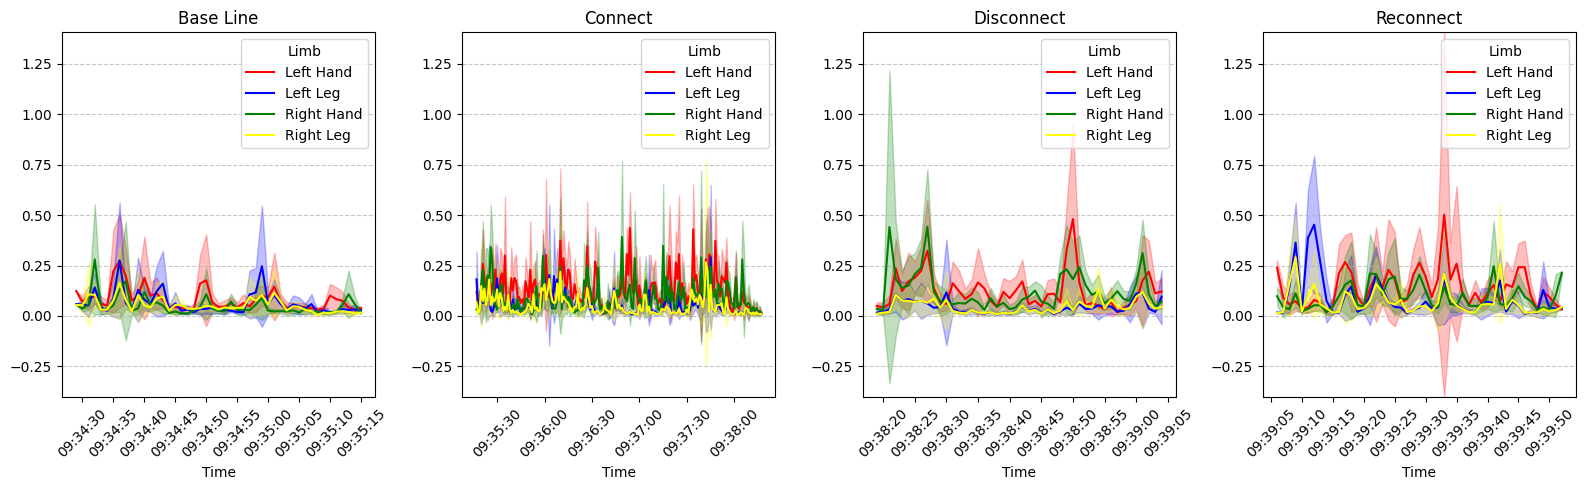

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Nothing to plot?
if not segmented_data:
    print("No segmented data to plot.")
else:
    # Compute global y-limits from mean +/- std across all events and limbs
    all_lower = []
    all_upper = []
    for data in segmented_data.values():
        res_mean = data.resample(stats_every).mean()
        res_std = data.resample(stats_every).std()
        if not res_mean.empty:
            lower = (res_mean - res_std).values
            upper = (res_mean + res_std).values
            all_lower.append(lower.flatten())
            all_upper.append(upper.flatten())
    if all_lower and all_upper:
        try:
            y_min = float(np.nanmin(np.concatenate(all_lower)))
            y_max = float(np.nanmax(np.concatenate(all_upper)))
        except Exception:
            y_min, y_max = None, None
    else:
        y_min, y_max = None, None

    n_events = len(segmented_data)
    fig_width = max(6, 4 * n_events)
    fig, axes = plt.subplots(1, n_events, figsize=(fig_width, 5))
    if n_events == 1:
        axes = [axes]

    for ax, (event_name, data) in zip(axes, segmented_data.items()):
        if data.empty:
            ax.set_title(f"{event_name} (no data)")
            continue

        # Resample to get mean and std per interval
        res_mean = data.resample(stats_every).mean()
        res_std = data.resample(stats_every).std()
        idx = res_mean.index
        if len(idx) == 0:
            ax.text(0.5, 0.5, "Not enough data to resample", ha='center')
            ax.set_title(event_name)
            continue

        for col in data.columns:
            mean_vals = res_mean[col]
            std_vals = res_std[col].fillna(0)
            color = colors.get(col, 'gray')
            # Plot mean line
            ax.plot(idx, mean_vals, label=col, color=color)
            # Fill ±1 std
            try:
                ax.fill_between(idx.to_pydatetime(), (mean_vals - std_vals), (mean_vals + std_vals),
                                color=color, alpha=0.25)
            except Exception:
                # fallback if datetime conversion fails
                ax.fill_between(np.arange(len(mean_vals)), (mean_vals - std_vals), (mean_vals + std_vals),
                                color=color, alpha=0.25)

        ax.set_title(event_name)
        ax.set_xlabel("Time")
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)
        ax.legend(title="Limb", loc='upper right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

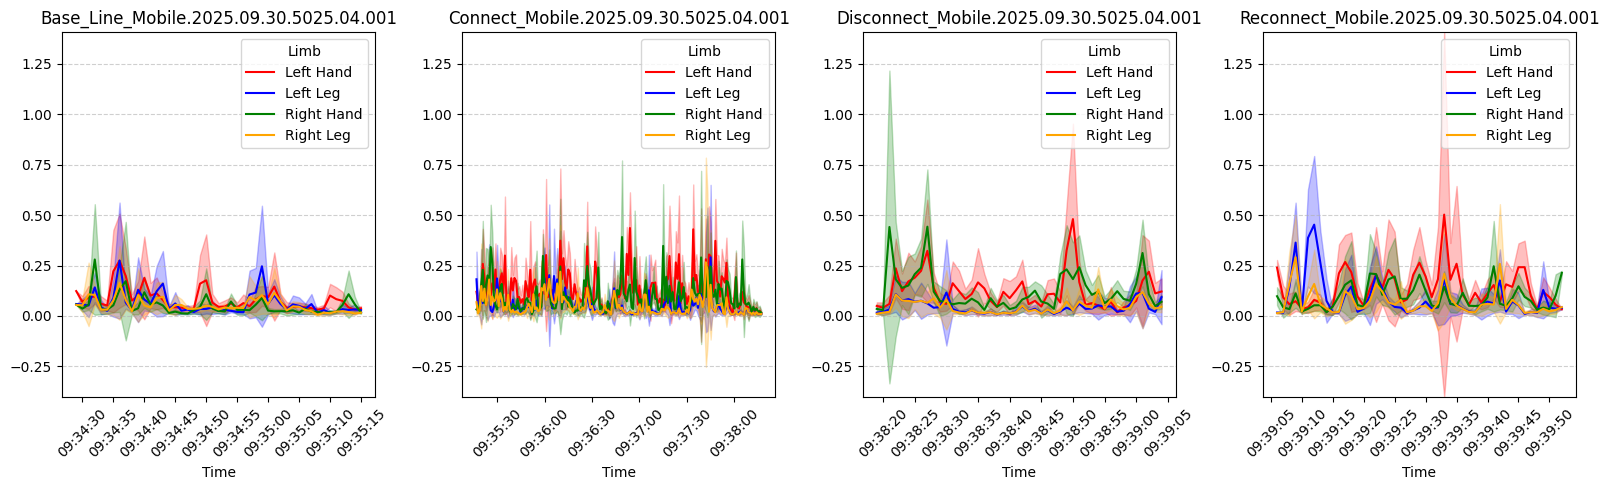

In [57]:
# Load all frames CSVs from the frames folder and plot mean ± 1 std for each limb
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path to frames directory (adjust if needed)
frames_dir = r"C:\Users\liors.WISMAIN\Weizmann Institute Dropbox\Lior Segev\Clients\Ofer_Izhar\Lital\Data\segments\frames"

files = sorted(glob.glob(os.path.join(frames_dir, "*_frames.csv")))
if not files:
    print(f"No frames CSVs found in: {frames_dir}")
else:
    # color map for limbs (reuse if available)
    colors = {
        'Left Hand': 'red',
        'Right Hand': 'green',
        'Left Leg': 'blue',
        'Right Leg': 'orange'
    }

    n_files = len(files)
    fig_w = max(6, 4 * n_files)
    fig, axes = plt.subplots(1, n_files, figsize=(fig_w, 5))
    if n_files == 1:
        axes = [axes]

    # compute global y-limits across all files for consistent scale
    global_lower = []
    global_upper = []
    for f in files:
        df = pd.read_csv(f)
        mean_cols = [c for c in df.columns if c.endswith('_mean')]
        std_cols = [c for c in df.columns if c.endswith('_std')]
        for m in mean_cols:
            s = m[:-5] + '_std'
            if s in df.columns:
                mean_vals = pd.to_numeric(df[m], errors='coerce').values
                std_vals = pd.to_numeric(df[s], errors='coerce').values
                if mean_vals.size:
                    global_lower.append((mean_vals - std_vals).flatten())
                    global_upper.append((mean_vals + std_vals).flatten())

    if global_lower and global_upper:
        try:
            y_min = float(np.nanmin(np.concatenate(global_lower)))
            y_max = float(np.nanmax(np.concatenate(global_upper)))
        except Exception:
            y_min, y_max = None, None
    else:
        y_min, y_max = None, None

    # Plot each file (one subplot per file)
    for ax, filepath in zip(axes, files):
        df = pd.read_csv(filepath)
        title = os.path.basename(filepath).replace('_frames.csv', '')
        # parse datetime column if present
        if 'datetime' in df.columns:
            try:
                df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
                x = df['datetime']
                xlabel = 'Time'
            except Exception:
                x = df['frame'] if 'frame' in df.columns else np.arange(len(df))
                xlabel = 'frame'
        else:
            x = df['frame'] if 'frame' in df.columns else np.arange(len(df))
            xlabel = 'frame'

        mean_cols = [c for c in df.columns if c.endswith('_mean')]
        limbs = [c[:-5] for c in mean_cols]

        for limb in limbs:
            mean_col = f"{limb}_mean"
            std_col = f"{limb}_std"
            if mean_col not in df.columns:
                continue
            mean_vals = pd.to_numeric(df[mean_col], errors='coerce')
            std_vals = pd.to_numeric(df[std_col], errors='coerce') if std_col in df.columns else pd.Series(0, index=df.index)
            color = colors.get(limb, None)
            line, = ax.plot(x, mean_vals, label=limb, color=color)
            # fill ±1 std
            try:
                ax.fill_between(x, (mean_vals - std_vals), (mean_vals + std_vals), color=line.get_color(), alpha=0.25)
            except Exception:
                ax.fill_between(np.arange(len(mean_vals)), (mean_vals - std_vals), (mean_vals + std_vals), color=line.get_color(), alpha=0.25)

        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.legend(title='Limb', loc='upper right')
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        if y_min is not None and y_max is not None:
            ax.set_ylim(y_min, y_max)
        if xlabel == 'Time':
            plt.setp(ax.get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()
